# Predicting Student Admissions

In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

In [1]:
!KERAS_BACKEND=tensorflow python -c "from keras import backend"

Using TensorFlow backend.


## Imports

In [2]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Preprocessing
from sklearn.preprocessing import PolynomialFeatures

# Dataset
from sklearn.datasets import load_boston

# Other
from IPython.display import Image
import configparser
import subprocess
import warnings
import pprint
import time
import os

## Prepare Principal Directory

In [14]:
def prepare_directory_work(end_directory: str='examples'):
    # Current path
    curr_dir = os.path.dirname(os.path.realpath("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}'

In [15]:
prepare_directory_work(end_directory='examples')

'Current working directory: /home/campos/projects/artificial_inteligence/machine_learning/supervised_learning/linear_models/linear_regression'

## Cell Format

In [16]:
# hide_code
# Guarantees visualization inside the jupyter
%matplotlib inline

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Format the data os all table (float_format 3)
pd.set_option('display.float_format', '{:.6}'.format)

# Print xxxx rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# Pretty print
pp = pprint.PrettyPrinter(indent=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data
- Colunas
    - **Country** – O país em que a pessoa nasceu.
    - **Life expectancy** – A expectativa de vida média ao nascer para uma pessoa nesse país.
    - **BMI** – O IMC médio para homens nesse país

In [98]:
%%time

data = pd.read_csv('data/raw/student_data.csv')
data.head()

CPU times: user 2.61 ms, sys: 0 ns, total: 2.61 ms
Wall time: 1.95 ms


,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.0,1
3,1,640,3.19,4
4,0,520,2.93,4


In [99]:
# get indexes
rows = 84
datasets = round(len(data)/rows) # total datasets
index_list = []

for index in data.index:
    x = index % rows    
    if x == 0:
        index_list.append(index)
        
print(index_list)

[0, 84, 168, 252, 336]


In [104]:
# split dataset by indexes
l_mod = index_list + [max(index_list)+1]

dfs_list = [data.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)]

print(len(dfs_list))

5


In [106]:
# output 
print(type(dfs_list[1]))
# pandas.core.frame.DataFrame

print(len(dfs_list[0]))
# 84

<class 'pandas.core.frame.DataFrame'>
84


In [6]:
type(boston_dataset)

sklearn.utils.Bunch

In [7]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [8]:
print(X.shape)
print(y.shape)

(506, 13)
(506,)


In [9]:
df_boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33


#### Add Target Column

In [10]:
df_boston['TARGET'] = boston_dataset.target

In [11]:
df_boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
TARGET     506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


## Missing Values

In [12]:
df_boston.isnull().any()

CRIM       False
ZN         False
INDUS      False
CHAS       False
NOX        False
RM         False
AGE        False
DIS        False
RAD        False
TAX        False
PTRATIO    False
B          False
LSTAT      False
TARGET     False
dtype: bool

## Duplicate

In [28]:
df_boston.duplicated().any()

False

## Outliers

In [39]:
df_boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
count,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0
mean,3.61352,11.3636,11.1368,0.06917,0.554695,6.28463,68.5749,3.79504,9.54941,408.237,18.4555,356.674,12.6531,22.5328
std,8.60155,23.3225,6.86035,0.253994,0.115878,0.702617,28.1489,2.10571,8.70726,168.537,2.16495,91.2949,7.14106,9.1971
min,0.00632,0.0,0.46,0.0,0.385,3.561,2.9,1.1296,1.0,187.0,12.6,0.32,1.73,5.0
25%,0.082045,0.0,5.19,0.0,0.449,5.8855,45.025,2.10018,4.0,279.0,17.4,375.377,6.95,17.025
50%,0.25651,0.0,9.69,0.0,0.538,6.2085,77.5,3.20745,5.0,330.0,19.05,391.44,11.36,21.2
75%,3.67708,12.5,18.1,0.0,0.624,6.6235,94.075,5.18843,24.0,666.0,20.2,396.225,16.955,25.0
max,88.9762,100.0,27.74,1.0,0.871,8.78,100.0,12.1265,24.0,711.0,22.0,396.9,37.97,50.0


In [37]:
# quantile()

dict_quantile = {}


def calculate_quantile_by_col(df: 'dataframe', *columns: list) -> None:
    """
    Calculate boxplot
    """
    for column in columns:
        dict_col = {}
       
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1  # Interquartile range

        dict_col[column] = {'q1': q1,
                            'q3': q3,
                            'iqr': iqr}
        # add dict column in principal dict
        dict_quantile.update(dict_col)


def calculate_fence(dict_col: 'dataframe', *columns: list) -> None:
    for column in columns:
        dict_actual_col = dict_col[column]  # mount internal dict of dict_quantile
        dict_fence = {}  # auxiliar dict
        
        fence_low  = dict_actual_col['q1'] - 1.5 * dict_actual_col['iqr']
        fence_high = dict_actual_col['q3'] + 1.5 * dict_actual_col['iqr']
        
        dict_fence = {'fence_low': fence_low,
                     'fence_high': fence_high}
        
        # add dict column in principal dict
        dict_col[column].update(dict_fence)


def count_outlier(df: 'dataframe', dict_quantile: dict, *columns: list):
    for column in columns:
        # mount internal dict of dict_quantile
        dict_actual_col = dict_quantile[column]

        outlier_less_q1 = (df[column] < dict_actual_col['fence_low']).sum()  # numpy.int64
        outlier_more_q3 = (df[column] > dict_actual_col['fence_high']).sum()  # numpy.int64
        total = outlier_less_q1 + outlier_more_q3
        
        dict_outlier = {'outlier_less_q1': outlier_less_q1,
                        'outlier_more_q3': outlier_more_q3,
                        'outlier_total': total}
        
        # add dict column in principal dict
        dict_quantile[column].update(dict_outlier)
        
    print("-"*25, "Dict Quantilie", "-"*25, end='\n\n')
    return pp.pprint(dict_quantile)


def check_quat_outlier(df: 'dataframe', dict_quantile: dict, *columns: list):
    outlier_total = 0
    total_lines = df.shape[0]
    total_cells = np.product(df.shape)
    
    print("-"*15, "OUTLIERS", "-"*15)
    print("\nSHAPE of data: {}".format(df.shape[0]))
    print("\nPERCENTAGE outlier by column:") 
    
    # by column
    for column in columns:
        dict_actual_col = dict_quantile[column]  # mount internal dict of dict_quantile
        outlier_total += dict_actual_col['outlier_total']

        quant_outlier_by_col = dict_actual_col['outlier_total']
        percentage_outlier_by_col = (quant_outlier_by_col/total_lines) * 100
        
        print("{}: {:4.4} %".format(column, percentage_outlier_by_col)) 

        
    percentage_by_line = (outlier_total/total_lines) * 100
    percentage_by_cell = (outlier_total/total_cells) * 100
        
    print("PERCENTAGE outlier by line: {:2.3} %".format(percentage_by_line))
    print("PERCENTAGE outlier by cell: {:2.3} %".format(percentage_by_cell))
    print("\nTOTAL outlier: {}".format(outlier_total))

In [44]:
# run
calculate_quantile_by_col(df_boston, *df_boston.columns)

calculate_fence(dict_quantile, *df_boston.columns)

count_outlier(df_boston, dict_quantile, *df_boston.columns)

------------------------- Dict Quantilie -------------------------

{   'AGE': {   'fence_high': 167.64999999999998,
               'fence_low': -28.54999999999999,
               'iqr': 49.04999999999999,
               'outlier_less_q1': 0,
               'outlier_more_q3': 0,
               'outlier_total': 0,
               'q1': 45.025,
               'q3': 94.07499999999999},
    'B': {   'fence_high': 427.49625000000003,
             'fence_low': 344.10624999999993,
             'iqr': 20.847500000000025,
             'outlier_less_q1': 77,
             'outlier_more_q3': 0,
             'outlier_total': 77,
             'q1': 375.3775,
             'q3': 396.225},
    'CHAS': {   'fence_high': 0.0,
                'fence_low': 0.0,
                'iqr': 0.0,
                'outlier_less_q1': 0,
                'outlier_more_q3': 35,
                'outlier_total': 35,
                'q1': 0.0,
                'q3': 0.0},
    'CRIM': {   'fence_high': 9.06963875,
           

In [45]:
check_quat_outlier(df_boston, dict_quantile, *df_boston.columns)

--------------- OUTLIERS ---------------

SHAPE of data: 506

PERCENTAGE outlier by column:
CRIM: 13.04 %
ZN: 13.44 %
INDUS:  0.0 %
CHAS: 6.917 %
NOX:  0.0 %
RM: 5.929 %
AGE:  0.0 %
DIS: 0.9881 %
RAD:  0.0 %
TAX:  0.0 %
PTRATIO: 2.964 %
B: 15.22 %
LSTAT: 1.383 %
TARGET: 7.905 %
PERCENTAGE outlier by line: 67.8 %
PERCENTAGE outlier by cell: 4.84 %

TOTAL outlier: 343


In [46]:
def plot_box_plot(df: 'dataframe', data_set_name: str, xlim=None):
    """
    Creates a seaborn boxplot including all dependent
    
    Args:
    data_set_name: Name of title for the boxplot
    xlim: Set upper and lower x-limits
    
    Returns:
    Box plot with specified data_frame, title, and x-limits 
    """
    fig, ax = plt.subplots(figsize=(18, 10))

    if xlim is not None:
        plt.xlim(*xlim)
    
    plt.title(f"Horizontal Boxplot {data_set_name}")
        
    plt.ylabel('Dependent Variables')
    plt.xlabel('Measurement x')
    ax = sns.boxplot(data = df,
                    orient = 'h', 
                    palette = 'Set2',
                    notch = False, # box instead of notch shape 
                    sym = 'rs')  # red squares for outliers

    plt.show()

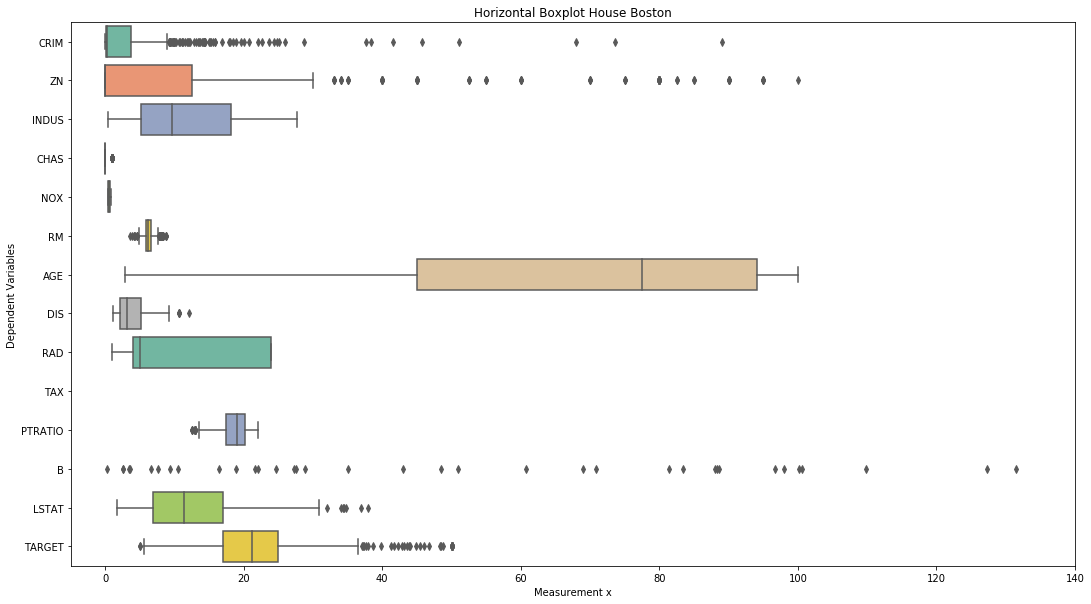

In [75]:
plot_box_plot(df_boston, 
              'House Boston', 
              (-5, 140))

---

# Descriptive Statistics
- Central Trend Measures
- Formal Measurements
- Dispersion Measurements
- Relationship Measures

In [13]:
df_boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
TARGET     506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


## Central Trend Measures

In [14]:
def show_measures_location(df: 'dataframe', type_descr: 'list') -> None:
    """
    Function get summary statistic 
    
    Args:
    type_descr
        np.number, np.object  -> return summary statistic with all columns
        np.number             -> return summary statistic numerical columns 
        np.object             -> return summary statistic object columns
    """
    try:
        col = (df.describe(include=type_descr).columns)  # pandas.core.indexes.base.Index  
    except ValueError:
        print(f'Dataframe not contains {type_descr} columns !', end='\n\n')    
    else:
        list_col = col.tolist()
        percentage = (len(list_col) / df.shape[1]) * 100
        
        print("-"*25, "MEASURES OF LOCALIZATION", "-"*25, end='\n\n')
        print(f"TOTAL columns {type_descr}: {len(list_col)}")
        print("PERCENTAGE {} in dataframe: {:3.4} %".format(type_descr, percentage))
        
        return df.describe(include=type_descr)

In [15]:
show_measures_location(df=df_boston,
                       type_descr=[np.number, np.object])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'numpy.number'>, <class 'object'>]: 14
PERCENTAGE [<class 'numpy.number'>, <class 'object'>] in dataframe: 100.0 %


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
count,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0
mean,3.61352,11.3636,11.1368,0.06917,0.554695,6.28463,68.5749,3.79504,9.54941,408.237,18.4555,356.674,12.6531,22.5328
std,8.60155,23.3225,6.86035,0.253994,0.115878,0.702617,28.1489,2.10571,8.70726,168.537,2.16495,91.2949,7.14106,9.1971
min,0.00632,0.0,0.46,0.0,0.385,3.561,2.9,1.1296,1.0,187.0,12.6,0.32,1.73,5.0
25%,0.082045,0.0,5.19,0.0,0.449,5.8855,45.025,2.10018,4.0,279.0,17.4,375.377,6.95,17.025
50%,0.25651,0.0,9.69,0.0,0.538,6.2085,77.5,3.20745,5.0,330.0,19.05,391.44,11.36,21.2
75%,3.67708,12.5,18.1,0.0,0.624,6.6235,94.075,5.18843,24.0,666.0,20.2,396.225,16.955,25.0
max,88.9762,100.0,27.74,1.0,0.871,8.78,100.0,12.1265,24.0,711.0,22.0,396.9,37.97,50.0


## Shape Measures

In [16]:
def show_measures_shape(df: 'dataframe', *columns: 'list') -> 'dataframe':
    index = ['skew', 'kurtosis'] 
    df_temp = pd.DataFrame(index=[index])
        
    print("-"*25, "MEASURES OF SHAPE", "-"*25, end='\n')
    
    for column in columns:
        list_temp = []
                
        list_temp.append(df[column].skew())
        list_temp.append(df[column].kurt())
        
        df_temp[column] = list_temp
    
    return df_temp

In [17]:
show_measures_shape(df_boston, *df_boston.columns)

------------------------- MEASURES OF SHAPE -------------------------


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
skew,5.22315,2.22567,0.295022,3.4059,0.729308,0.403612,-0.598963,1.01178,1.00481,0.669956,-0.802325,-2.89037,0.90646,1.1081
kurtosis,37.1305,4.03151,-1.23354,9.63826,-0.0646671,1.8915,-0.967716,0.487941,-0.867232,-1.14241,-0.285091,7.22682,0.49324,1.4952


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa872a210b8>,
      dtype=object)

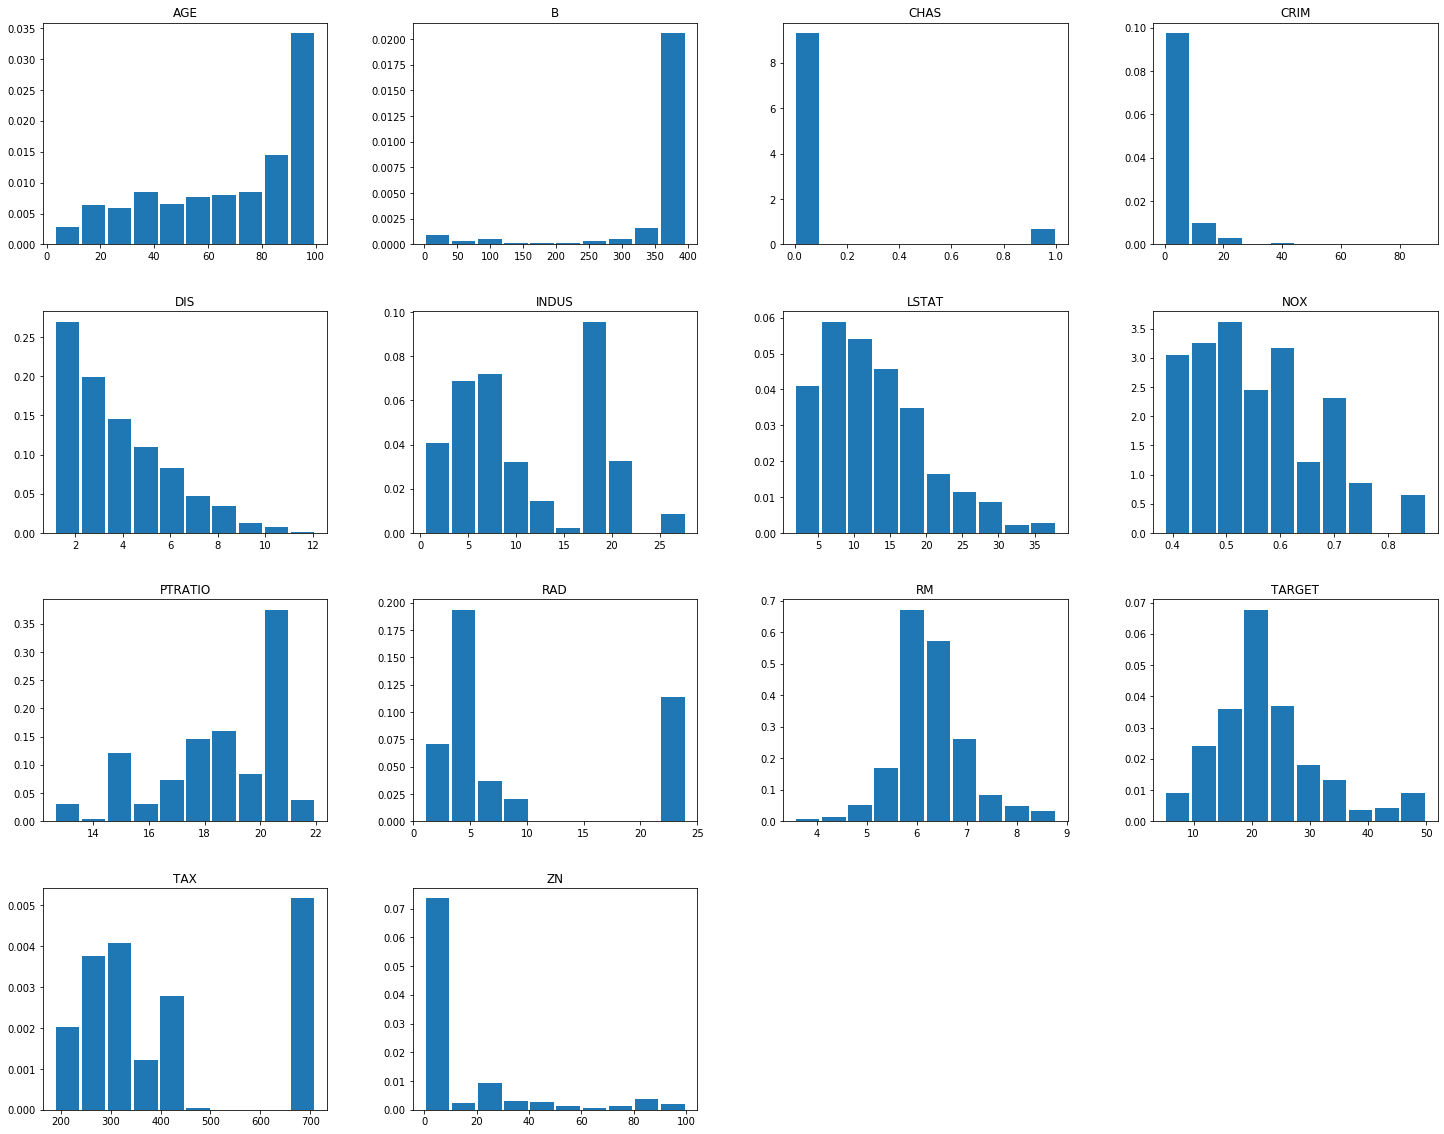

In [18]:
# Distribuition
df_boston.hist(figsize=[25,20],
                density=True, 
                bins=10, 
                grid=False, 
                zorder=2, 
                rwidth=0.9)

## Relational Measures

In [19]:
df_boston.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
CRIM,1.0,-0.200469,0.406583,-0.0558916,0.420972,-0.219247,0.352734,-0.37967,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.0,-0.533828,-0.0426967,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.17552,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.0,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.72076,0.383248,-0.356977,0.6038,-0.483725
CHAS,-0.0558916,-0.0426967,0.062938,1.0,0.0912028,0.0912512,0.0865178,-0.0991758,-0.00736824,-0.0355865,-0.121515,0.0487885,-0.0539293,0.17526
NOX,0.420972,-0.516604,0.763651,0.0912028,1.0,-0.302188,0.73147,-0.76923,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.0912512,-0.302188,1.0,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.69536
AGE,0.352734,-0.569537,0.644779,0.0865178,0.73147,-0.240265,1.0,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.37967,0.664408,-0.708027,-0.0991758,-0.76923,0.205246,-0.747881,1.0,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.00736824,0.611441,-0.209847,0.456022,-0.494588,1.0,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.72076,-0.0355865,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.0,0.460853,-0.441808,0.543993,-0.468536


In [80]:
def plot_correlation(df):
    plt.figure(figsize = (25,20))
    plt.title('Correlation Features', y=1.00, size=45)

    correlation = df.corr(method='pearson')
    
    correlation_img = sns.heatmap(correlation, 
                                    annot=True, 
                                    linecolor='white',
                                    linewidths=.1,
                                    cmap="RdYlGn")
    plt.autoscale()

    return correlation_img

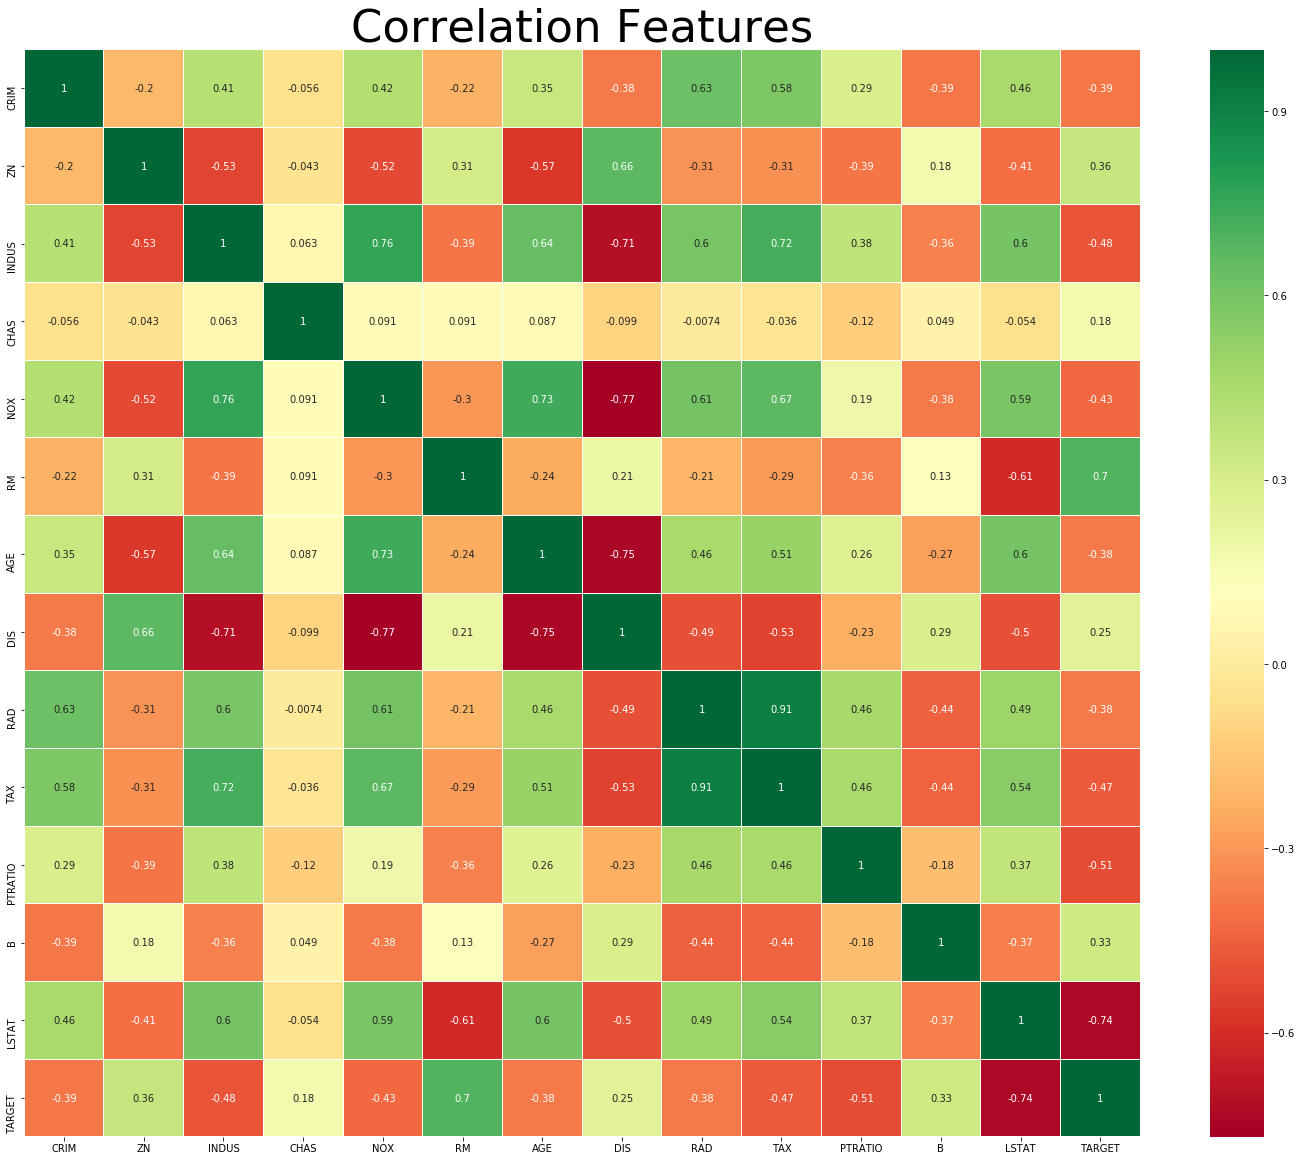

In [81]:
correlation_img = plot_correlation(df_boston)

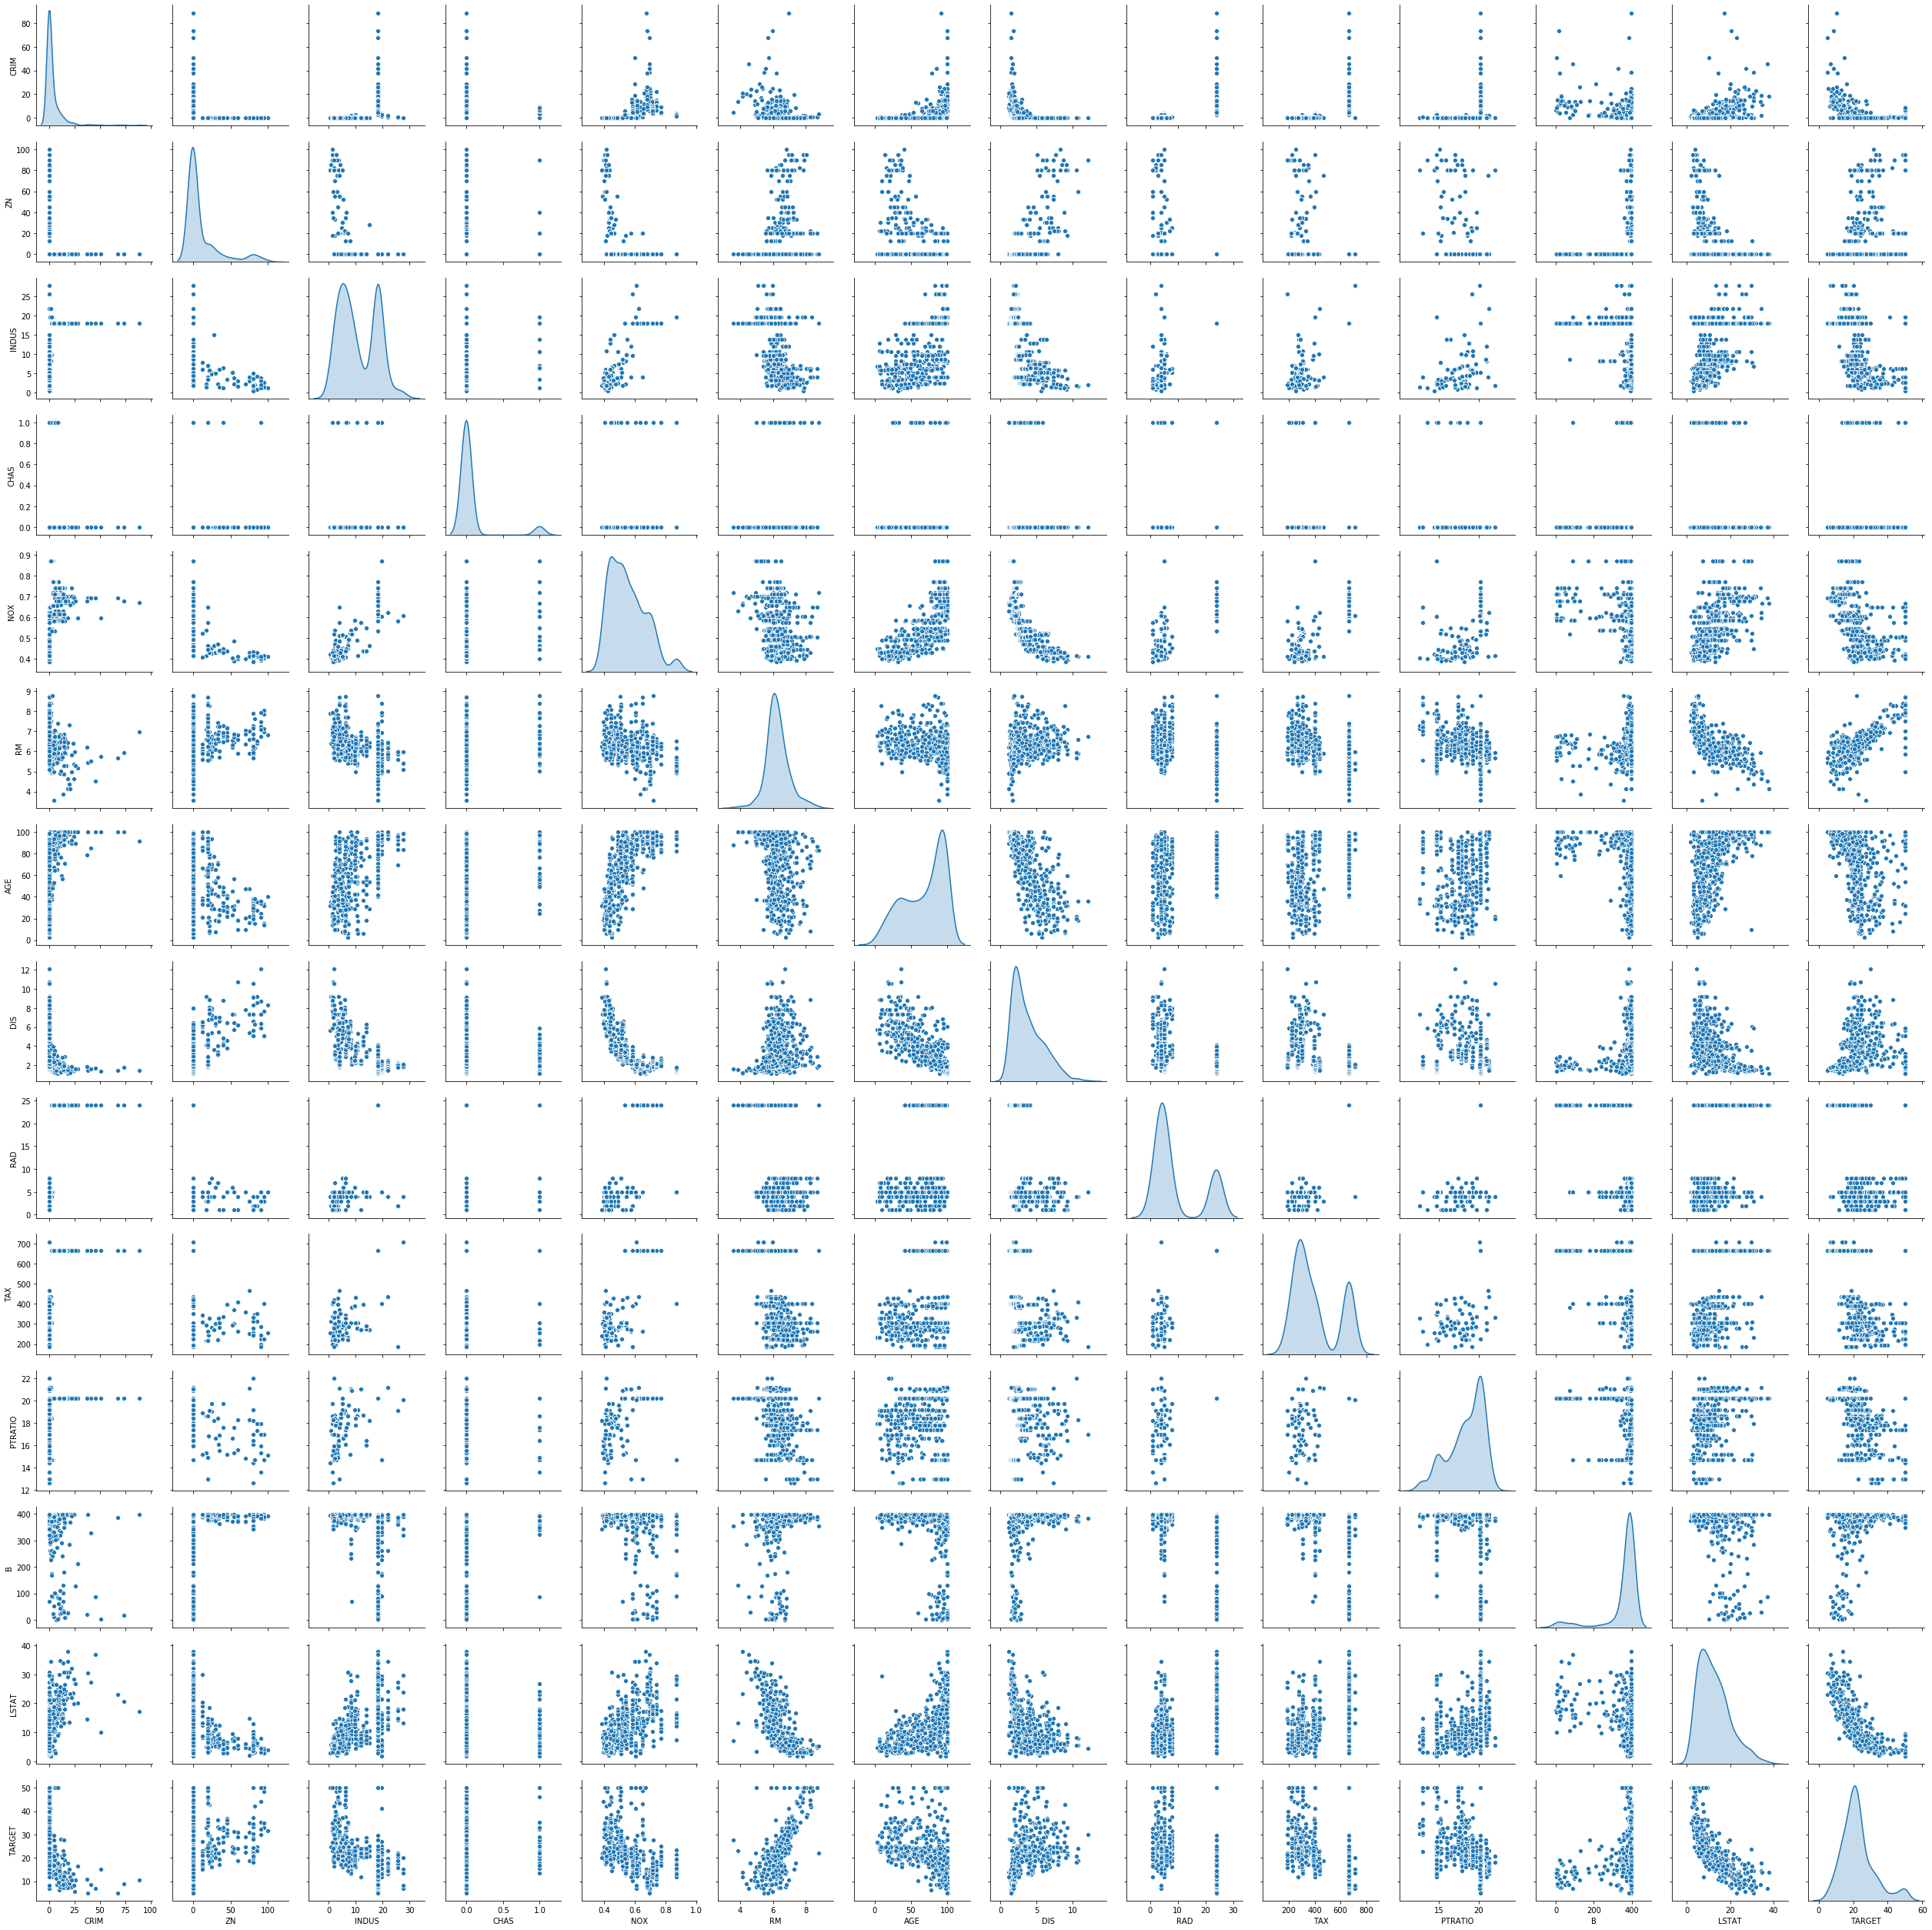

In [22]:
corr_client_data = sns.pairplot(df_boston, 
                                 kind = 'scatter',
                                 diag_kind='kde')
display(corr_client_data)

#### The Best Correlations

In [23]:
def top_corr(df: 'dataframe', list_col: 'list', n_corr: int = 20, corr_method: str = 'pearson') -> 'Series':
    corr_top_list = df[list_col].corr(method=corr_method).abs()

    s = corr_top_list.unstack()
    sortedSeries = s.sort_values(kind="quicksort",ascending=False)
    best_correlation = sortedSeries[sortedSeries != 1.0][0:n_corr]

    print("-"*25, "TOP CORRELATED IN PAIRS", "-"*25, end='\n\n')
    return best_correlation

In [24]:
top_corr(df=df_boston,
         list_col=df_boston.columns)

------------------------- TOP CORRELATED IN PAIRS -------------------------



RAD     TAX      0.910228
TAX     RAD      0.910228
NOX     DIS       0.76923
DIS     NOX       0.76923
INDUS   NOX      0.763651
NOX     INDUS    0.763651
AGE     DIS      0.747881
DIS     AGE      0.747881
LSTAT   TARGET   0.737663
TARGET  LSTAT    0.737663
AGE     NOX       0.73147
NOX     AGE       0.73147
TAX     INDUS     0.72076
INDUS   TAX       0.72076
DIS     INDUS    0.708027
INDUS   DIS      0.708027
RM      TARGET    0.69536
TARGET  RM        0.69536
NOX     TAX      0.668023
TAX     NOX      0.668023
dtype: float64

## Feature Selection
- correlation < 0.1% with the feature `TARGET`
- Are fully independent feature

In [25]:
def get_without_correlation(df, list_col, target_col):
    corr_list = df[list_col].corr().abs()

    s = corr_list.unstack()
    sorted_series = s\
                    .sort_values(kind="quicksort",ascending=True)\
                        .get(target_col)
    if sorted_series is None:
        return print('All columns have correlation with target column.')

    without_correlation = sorted_series[sorted_series < 0.1][0:-1]

    print("-"*25, "WITHOUT CORRELATED WITH TARGET", "-"*25, end='\n\n')
    print(without_correlation)
    return without_correlation.index.tolist()

In [26]:
def remove_without_corr(df: 'dataframe', list_without_corr: list) -> int:
    print(f'Columns before = {df.shape[1]}')

    for column in list_without_corr:
        del df[column]
    
    return print(f"Columns after = {df.shape[1]}")

In [27]:
list_without_corr = get_without_correlation(df = df_boston,
                                            list_col = df_boston.columns,
                                            target_col = 'TARGET')

------------------------- WITHOUT CORRELATED WITH TARGET -------------------------

Series([], dtype: float64)


---

## Prepare Tranning

In [48]:
house_data = load_boston()
X = house_data['data']
y = house_data['target']

## Split Data

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(404, 13)
(404,)
(102, 13)
(102,)


## Create Model

In [50]:
lr_model = LinearRegression()

## Train Model

In [51]:
lr_model = lr_model.fit(X_train, y_train)

Finalmente, com o modelo treinado, podemos realizar previsões e ver quão próximas elas estão da realidade.

Podemos fazer previsões com os **dados de teste** ou senão com algum valor do eixo X (IMC).

## Make Predictions

In [52]:
y_test_predict = lr_model.predict(X_test)

## Model Evaluation

In [53]:
# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)

print("The model performance in TESTING")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance in TESTING
--------------------------------------
RMSE is 4.568292042303218
R2 score is 0.7334492147453064


---

## Polynomial Regression

In [57]:
poly = PolynomialFeatures(degree=2)
  
# transforms the existing features to higher degree features.
X_train_poly = poly.fit_transform(X_train)

## Create Model

In [58]:
poly_model = LinearRegression()

## Train Model

In [59]:
poly_model.fit(X_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Make Predictions

In [60]:
y_test_predict = poly_model.predict(poly.fit_transform(X_test))

## Model Evaluation

In [61]:
# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)

print("The model performance in TESTING")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance in TESTING
--------------------------------------
RMSE is 3.196527651203868
R2 score is 0.8694943908890794


---

## Linear Regression with Regularization

## Create Model

In [62]:
regularization_model = Ridge(alpha=0.1)

## Train Model

In [63]:
regularization_model.fit(X, y)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

## Make Predictions

In [64]:
y_test_predict = regularization_model.predict(X_test)

## Model Evaluation

In [65]:
# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
r2 = r2_score(y_test, y_test_predict)

print("The model performance in TESTING")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance in TESTING
--------------------------------------
RMSE is 4.3190415171385785
R2 score is 0.7617422674921209


## Note
- The model explain ~87% of variables house price !
- The best linear regression is: **Polynomial Regression** with degree 2

---